### Improving Parking Meter Revenue by Prioritizing Street Maintinence Requests

My original goal for this project was to determine if street maintinence affects the revenue of parking meters. This idea came from my own experience parking in San Diego, dodging construction zones and avoiding potholes. My approach was to use geospatial methods to combine the meter locations and maintinence requests using a proximity buffer. From there I was able to determine meter revenue before and after the maitenence request was closed. I used the difference between the pre and post revenues to create a categorical priority system. I used a Hypothesis Test using the bootstrap to determine which maintinence request types were most valueable to be completed first. Lastly I trained some machine learning models to predict 

My datasets originated from San Diego's open data portal, links to datasets can be found below.

Parking Meter Locations: https://data.sandiego.gov/datasets/parking-meters-locations/
Parking Meter Transactions: https://data.sandiego.gov/datasets/parking-meters-transactions/
Get It Done Applications(Maintinence Requests): https://data.sandiego.gov/datasets/get-it-done-311/

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
from datetime import timedelta
import zipfile
import folium
import json

In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [30]:
with zipfile.ZipFile("cleared.zip",mode="r") as cleared_ref:
    cleared_ref.extractall()
    
with zipfile.ZipFile("parking_payments.zip",mode="r") as payment_ref:
    payment_ref.extractall()
    
COLOR_M = '#702963'#main color
COLOR_F = '#F2F2F2' #background color

In [31]:
#File locations
INCIDENTS = 'incidents.csv'
METERS = 'parking_meters.csv'
PAYMENTS = 'parking_payments.csv'
CLEARED = 'cleared.csv'
#read files
incidents_raw = pd.read_csv(INCIDENTS)
meter_raw = pd.read_csv(METERS)
payment_raw = pd.read_csv(PAYMENTS)
cleared_raw = pd.read_csv(CLEARED, low_memory=False)

In [32]:
#How many unqique poles
#4257
#find meter time
test_ste = payment_raw.date_trans_start[0]
datetime.fromisoformat(test_ste)

to_datetime = lambda x: datetime.fromisoformat(x)
payment_raw.date_trans_start = payment_raw.date_trans_start.apply(to_datetime)
payment_raw.date_meter_expire = payment_raw.date_meter_expire.apply(to_datetime)

payment_raw['time'] = payment_raw.date_meter_expire - payment_raw.date_trans_start


In [33]:
#drop transactions for zero time
zero_payment = payment_raw[payment_raw.time <= timedelta()].index
payment_raw.drop(zero_payment, inplace=True)
#Parking meters are only active Mon-Sat meaning 'Sunday Mode' meters are duplicates
#drop Sunday Mode meters
sunday_meters = meter_raw[meter_raw.config_name == 'Sunday Mode'].index
meter_raw.drop(sunday_meters, inplace=True)

In [34]:
incidents_raw.service_name.value_counts()

Sidewalk Repair Issue                      9712
Encampment                                 9604
Street Light Maintenance                   7804
Pavement Maintenance                       6179
Parking                                    5447
Graffiti                                   4388
Traffic Sign Maintenance                   3365
Illegal Dumping                            3012
ROW Maintenance                            2414
Right-of-Way Code Enforcement              1849
Development Services - Code Enforcement    1495
Graffiti - Code Enforcement                1222
Stormwater                                 1181
Tree Maintenance                           1028
Traffic Engineering                         976
Environmental Services Code Compliance      831
Parks Issue                                 445
Street Sweeping                             364
Missed Collection                           302
Pothole                                     275
Stormwater Code Enforcement             

In [35]:
graph_1_data = incidents_raw.service_name.value_counts()
graph_1_cols = graph_1_data.index[0:8]
other_count = graph_1_data.drop(graph_1_cols).sum()
graph_1_data['Other'] = other_count
display(graph_1_data)


graph_1_data = graph_1_data.loc[graph_1_cols]


graph_1_style = {
    'kind':'barh',
    'figsize':(10,10),
    'fontsize':14,
    'color':COLOR_M
    
}

Sidewalk Repair Issue                       9712
Encampment                                  9604
Street Light Maintenance                    7804
Pavement Maintenance                        6179
Parking                                     5447
Graffiti                                    4388
Traffic Sign Maintenance                    3365
Illegal Dumping                             3012
ROW Maintenance                             2414
Right-of-Way Code Enforcement               1849
Development Services - Code Enforcement     1495
Graffiti - Code Enforcement                 1222
Stormwater                                  1181
Tree Maintenance                            1028
Traffic Engineering                          976
Environmental Services Code Compliance       831
Parks Issue                                  445
Street Sweeping                              364
Missed Collection                            302
Pothole                                      275
Stormwater Code Enfo

<AxesSubplot:title={'center':'Most Common Request Types'}, xlabel='Number of Requests'>

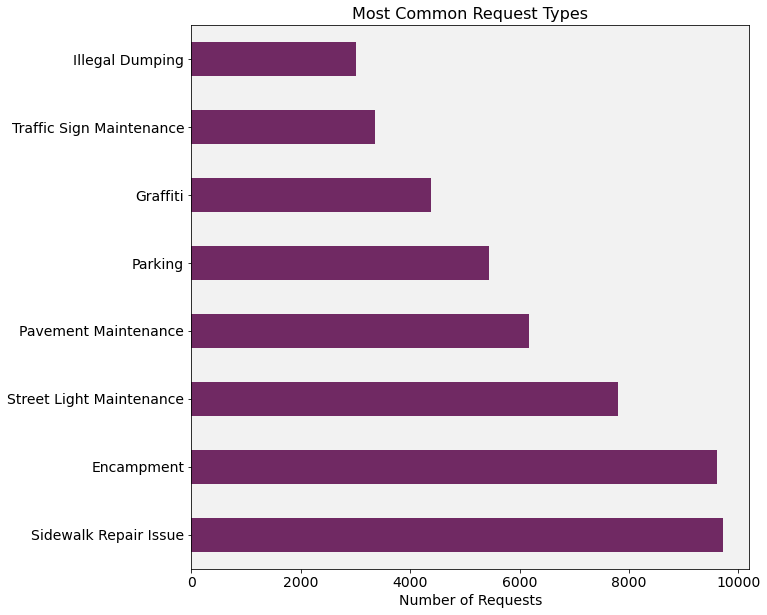

In [36]:
graph_1 = graph_1_data.plot(**graph_1_style)
graph_1.set_facecolor(COLOR_F)
graph_1.set_xlabel('Number of Requests', fontsize=14)
graph_1.set_title('Most Common Request Types', fontsize=16)

graph_1

Text(0.5, 1.0, 'Payment Method Splits')

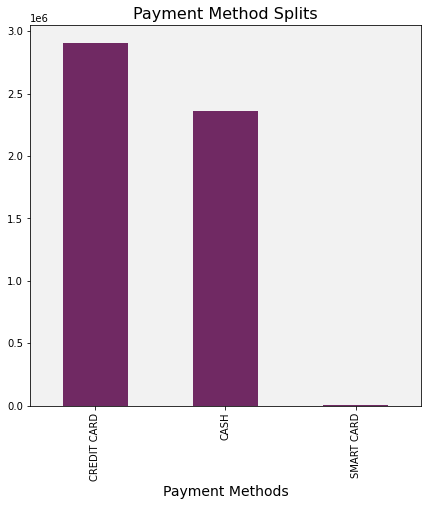

In [37]:
graph_2 = payment_raw.pay_method.value_counts().plot(color=COLOR_M,
                                                     figsize=(7,7),
                                                     kind='bar')
graph_2.set_facecolor(COLOR_F)
graph_2.set_xlabel('Payment Methods', fontsize=14)
graph_2.set_title('Payment Method Splits', fontsize=16)

338.2957651133501

Sidewalk Repair Issue                      9712
Encampment                                 9604
Street Light Maintenance                   7804
Pavement Maintenance                       6179
Parking                                    5447
Graffiti                                   4388
Traffic Sign Maintenance                   3365
Illegal Dumping                            3012
ROW Maintenance                            2414
Right-of-Way Code Enforcement              1849
Development Services - Code Enforcement    1495
Graffiti - Code Enforcement                1222
Stormwater                                 1181
Tree Maintenance                           1028
Traffic Engineering                         976
Environmental Services Code Compliance      831
Parks Issue                                 445
Street Sweeping                             364
Missed Collection                           302
Pothole                                     275
Stormwater Code Enforcement             

Downtown                        6501
Mid-City:City Heights           4589
Uptown                          4000
North Park                      3697
Southeastern San Diego          3277
Clairemont Mesa                 3196
Pacific Beach                   2544
Mid-City:Eastern Area           2162
La Jolla                        1998
Peninsula                       1993
Navajo                          1899
Mira Mesa                       1699
Otay Mesa-Nestor                1580
Skyline-Paradise Hills          1468
Encanto Neighborhoods           1428
Greater Golden Hill             1273
Mid-City:Normal Heights         1247
College Area                    1238
Balboa Park                     1187
Ocean Beach                     1168
Mission Valley                  1108
Mid-City:Kensington-Talmadge    1028
Midway-Pacific Highway          1024
University                       961
Kearny Mesa                      874
Mission Bay Park                 865
Rancho Bernardo                  862
R

,case_age_days
case_origin,
Famosa Patrol,9.000000
Self-Generated,38.823529
GID Field,41.615385
Worker App,49.024958
Residential Patrol,51.833333
Hauler List,89.140940
Irrigation Patrol,97.000000
CC Self Generate,132.916667
Construction Patrol,193.500000


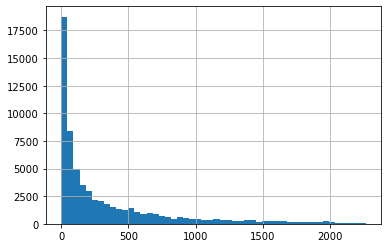

In [38]:
incidents_raw.columns
#average case age, case_age_days
display(incidents_raw.case_age_days.mean())
incidents_raw.case_age_days.hist(bins=50)
#service counts, service_name
display(incidents_raw.service_name.value_counts())
#count of incidents per municipality
display(incidents_raw.comm_plan_name.value_counts())
#case_origin with case age, case_origin/case_age_days
display(incidents_raw.loc[:,['case_origin', 'case_age_days']].groupby('case_origin').mean().sort_values('case_age_days'))

In [39]:
incidents_raw.loc[:,['case_origin','service_name','status']].groupby(['case_origin', 'service_name']).count().reset_index().groupby('service_name').apply(lambda x: x.sort_values('status', ascending=False))

case_origin  \
service_name                                                    
Dead Animal                             64              Phone   
                                        33             Mobile   
                                        96                Web   
Development Services - Code Enforcement 34             Mobile   
                                        97                Web   
...                                                       ...   
Waste on Private Property               90              Phone   
                                        3    CC Self Generate   
Weed Cleanup                            63             Mobile   
                                        125               Web   
                                        91              Phone   

                                                                        service_name  \
service_name                                                                           
Dead Animal                             64                               Dead Animal   
                                        33                               Dead Animal   
                                        96                               Dead Animal   
Development Services - Code Enforcement 34   Development Services - Code Enforcement   
                                        97   Development Services - Code Enforcement   
...                                                                              ...   
Waste on Private Property               90                 Waste on Private Property   
                                        3                  Waste on Private Property   
Weed Cleanup                            63                              Weed Cleanup   
                                        125                             Weed Cleanup   
                                        91                              Weed Cleanup   

                                             status  
service_name                                         
Dead Animal                             64       39  
                                        33       18  
                                        96        3  
Development Services - Code Enforcement 34     1290  
                                        97      191  
...                                             ...  
Waste on Private Property               90       16  
                                        3         1  
Weed Cleanup                            63      100  
                                        125      31  
                                        91        5  

[129 rows x 3 columns]

In [40]:
#add geometry and determine CRS
meter_df = gpd.GeoDataFrame(meter_raw, geometry=gpd.points_from_xy(meter_raw.lng, meter_raw.lat), crs='EPSG:4326').to_crs(epsg=3857)
incidents_df = gpd.GeoDataFrame(incidents_raw, geometry=gpd.points_from_xy(incidents_raw.lng, incidents_raw.lat),crs='EPSG:4326').to_crs(epsg=3857)
cleared_df = gpd.GeoDataFrame(cleared_raw, geometry=gpd.points_from_xy(cleared_raw.lng, cleared_raw.lat),crs='EPSG:4326').to_crs(epsg=3857)

In [41]:
ZIPS = 'zips.geojson'
zip_gdf = gpd.read_file(ZIPS).to_crs(epsg=3857)

#get only zipcodes that have a meter
meter_zips = zip_gdf.sjoin(meter_df, how='inner')
#get zipcodes that have a meter and at least one current GID request
incidents_zips = zip_gdf.loc[meter_zips.index.unique(),:].sjoin(incidents_df, how='inner')
#get zipcodes that have a meter and a resolved GID request
cleared_zips = zip_gdf.loc[meter_zips.index.unique(),:].sjoin(cleared_df, how='inner')

In [42]:
#only keep meters with incidents
VALID_METERS = meter_zips.index_right
meter_df = meter_df.loc[VALID_METERS]
VALID_INCIDENTS = incidents_zips.index_right
incidents_df = incidents_df.loc[VALID_INCIDENTS]
VALID_CLEARED = cleared_zips.index_right
cleared_df = cleared_df.loc[VALID_CLEARED]

POPULATED_ZIPS = cleared_zips.index


In [43]:
def fix_date(datestr):
    if pd.isna(datestr):
        return np.nan
    year, month, day = datestr.split('-')
    return datetime(int(year), int(month), int(day))

In [44]:
meter_buffer = meter_df.copy()
meter_buffer.geometry = meter_df.buffer(50)
valid_cleared = cleared_df.sjoin(meter_buffer,how='inner')
valid_cleared.reset_index(drop=True,inplace=True)
valid_cleared.date_closed = valid_cleared.date_closed.apply(fix_date)

In [45]:
zip_gdf_active = gpd.GeoSeries(zip_gdf.loc[POPULATED_ZIPS].groupby('ZIP').apply(lambda x: x.geometry.iloc[0]), crs='EPSG:3857')

zip_gjson = zip_gdf.geometry.to_crs('EPSG:4326').to_json()
zip_gjson_active = zip_gdf_active.to_crs('EPSG:4326').to_json()
cleared_gjson = cleared_df.geometry.to_crs('EPSG:4326').to_json()
meter_gjson = meter_buffer.geometry.to_crs('EPSG:4326').to_json()

#This solution is not pretty, but saves on memory costs and doesnt crash my pc
buffer_cleared = cleared_df.copy()
buffer_cleared['dummy_var'] = 1
buffer_cleared.geometry = cleared_df.buffer(5)
buffer_polygon = buffer_cleared.dissolve(by='dummy_var')

cleared_gjson =buffer_polygon.to_crs('EPSG:4326').to_json()

In [46]:
style_background_zips = lambda x: {'fillColor': '#D3D3D3',
                              'fillOpacity': 0.8,
                              'color':'gray'}
style_active_zips = lambda x: {'fillColor': '#6495ED',
                              'fillOpacity': 1,
                              'color':'blue'}
style_meter_buffs = lambda x: {'fillColor': '#FFBF00',
                              'fillOpacity': 1,
                              'color':'#CC5500'}
style_cleared_buffs = lambda x: {'fillColor': '#E30B5C',
                                 'fillOpacity': 1,
                                 'color':'#913831'}

fol_map = folium.Map(location=(32.731113, -117.145010), zoom_start=12, tiles='CartoDB positron')
folium.GeoJson(zip_gjson, name='zips_inactive', style_function=style_background_zips).add_to(fol_map)
folium.GeoJson(zip_gjson_active, name='zips_active', style_function=style_active_zips).add_to(fol_map)

folium.GeoJson(cleared_gjson, name='cleared', style_function=style_cleared_buffs).add_to(fol_map)
folium.GeoJson(meter_gjson, name='meters', style_function=style_meter_buffs).add_to(fol_map)


folium.LayerControl().add_to(fol_map)
fol_map.save('overall_map.html')

In [47]:
COLUMNS_CLEARED = ['service_request_id','date_requested', 'case_age_days','service_name',
                   'date_closed','zipcode','case_origin','geometry','pole',]
valid_cleared = valid_cleared.loc[:,COLUMNS_CLEARED]

In [48]:
valid_cleared.groupby('pole').count().service_request_id.describe()

count    6032.000000
mean       55.472149
std        61.393730
min         1.000000
25%        18.000000
50%        33.000000
75%        69.000000
max       560.000000
Name: service_request_id, dtype: float64

In [49]:
#average money made 2 weeks before accident resolve and money after 2 week of resolve
unique_poles = valid_cleared.pole.unique()
unique_poles_series = pd.Series(index=unique_poles,dtype=bool, name='poles')

payment_df = pd.merge(payment_raw, unique_poles_series,left_on='pole_id',right_index=True)

unique_poles = payment_df.pole_id.unique()
unique_poles_series = pd.Series(index=unique_poles,dtype=bool, name='poles')

valid_cleared = pd.merge(valid_cleared, unique_poles_series, left_on='pole', right_index=True)

In [50]:
cleared_date_left = valid_cleared.date_closed - valid_cleared.case_age_days.apply(lambda x: timedelta(days=x))

date_2020 = cleared_date_left.apply(lambda x: x.year < 2021)
date_2020 = valid_cleared[date_2020].index
valid_cleared.drop(date_2020,inplace=True)

cleared_date_right = valid_cleared.date_closed + valid_cleared.case_age_days.apply(lambda x: timedelta(days=x))
date_2022 = cleared_date_right.apply(lambda x: x.year > 2021)
date_2022 = valid_cleared[date_2022].index
valid_cleared.drop(date_2022, inplace=True)


In [51]:
valid_cleared_gjson = valid_cleared.dissolve(by='service_request_id').buffer(5).geometry.to_crs('EPSG:4326').to_json()

map_level_2 = folium.Map(location=(32.731341, -117.160302), zoom_start=17, tiles='CartoDB positron')
folium.GeoJson(meter_gjson, name='meters', style_function=style_meter_buffs).add_to(map_level_2)
folium.GeoJson(valid_cleared_gjson, name='incidents', style_function=style_cleared_buffs).add_to(map_level_2)

folium.LayerControl().add_to(map_level_2)

map_level_2.save('buffer_map.html')

In [52]:
def get_left_date(pmt, left_date, date):
    return left_date < pmt < date
def get_right_date(pmt, date, right_date):
    return date < pmt < right_date

def distance(x, y):
    return np.sqrt((x**2) + (y**2))
def categorize_differences(diff, low_end, high_end):
    if diff > high_end:
        return "High Priority"
    elif (diff > low_end) and (diff < high_end):
        return "Low Priority"
    else:
        return "No Priority"

In [53]:
payments_before_incident = []
payments_after_incident =  []
skipped = 0

pole_tuples = payment_df.groupby('pole_id').apply(lambda x: (x.date_trans_start, x.trans_amt))
pole_tuples

for incident in valid_cleared.index:
    pole = valid_cleared.pole[incident]
    try:
        pole_payments = pole_tuples[pole]
    except KeyError:
        payments_before_incident.append(np.nan)
        payments_after_incident.append(np.nan)
        skipped += 1
        continue
    pole_payments = pd.DataFrame({'date_trans_start':pole_payments[0],
                                  'trans_amt': pole_payments[1]})
    pole_payments_date = pole_payments.date_trans_start
    incident_date = valid_cleared.date_closed[incident]
    pay_before_date = pole_payments_date.apply(get_left_date, args=(cleared_date_left[incident], incident_date))
    pay_before_total = pole_payments[pay_before_date].trans_amt.sum()
    pay_after_date = pole_payments_date.apply(get_right_date, args=(incident_date, cleared_date_right[incident]))
    pay_after_total = pole_payments[pay_after_date].trans_amt.sum()
    
    payments_before_incident.append(pay_before_total)
    payments_after_incident.append(pay_after_total)
    
valid_cleared['payment_before'] = payments_before_incident
valid_cleared['payment_after'] = payments_after_incident
valid_cleared['payment_diff'] = valid_cleared.payment_after - valid_cleared.payment_before

valid_cleared.dropna(subset='payment_diff', inplace=True)

In [54]:
service_name_avgs = valid_cleared.groupby('service_name').apply(lambda x: x.payment_diff.mean()).sort_values()
service_name_avgs.name = 'payment_diff'

service_name_avgs

service_name
Right-of-Way Code Enforcement              -573.685921
Waste on Private Property                  -249.226442
Stormwater                                 -150.863579
COVID-19                                    -19.345178
Shared Mobility Device                        0.000000
Stormwater Code Enforcement                  47.269136
Weed Cleanup                                 60.371681
Street Flooded                               69.745583
Traffic Signal Timing                        71.154028
Dead Animal                                  88.461369
Other                                        89.021543
Development Services - Code Enforcement     118.087685
Traffic Signal Issue                        171.277940
Missed Collection                           207.633320
Illegal Dumping                             208.058094
Pothole                                     214.671504
Street Sweeping                             218.457711
Pavement Maintenance                        270.1878

In [55]:
service_name_cnts = valid_cleared.groupby('service_name').apply(lambda x: x.payment_diff.count()).sort_values()
service_name_cnts.name = "counts"

service_name_cnts

service_name
Homeless Outreach                             12
Oversized Vehicle                             34
Weed Cleanup                                 113
Right-of-Way Code Enforcement                277
Dead Animal                                  453
Pavement Maintenance                         559
Street Flooded                               566
Waste on Private Property                    711
Stormwater                                   799
Stormwater Code Enforcement                  810
Traffic Engineering                          979
COVID-19                                     985
Street Sweeping                             1005
Development Services - Code Enforcement     1015
Trash/Recycling Collection                  1191
Traffic Signal Timing                       1266
ROW Maintenance                             1895
Traffic Sign Maintenance                    2025
Environmental Services Code Compliance      2239
Sidewalk Repair Issue                       2248
Tree Ma

In [56]:
service_name_df = pd.merge(service_name_avgs, service_name_cnts, left_index=True, right_index=True).reset_index().sort_values('payment_diff')
service_name_df

,service_name,payment_diff,counts
0,Right-of-Way Code Enforcement,-573.685921,277
1,Waste on Private Property,-249.226442,711
2,Stormwater,-150.863579,799
3,COVID-19,-19.345178,985
4,Shared Mobility Device,0.000000,67525
5,Stormwater Code Enforcement,47.269136,810
6,Weed Cleanup,60.371681,113
7,Street Flooded,69.745583,566
8,Traffic Signal Timing,71.154028,1266
9,Dead Animal,88.461369,453


In [57]:
cleared_df[cleared_df['service_name'] == 'Other'].public_description

333362    Roosevelt Middle School Joint Use Park: Nov 16...
110369    Parks and Rec: the iceplant and bushes and sed...
304778                              Fire hydrant cap is off
140318    Bicycle chop shop on the canyon, behind the ba...
343808                                            Vandalism
                                ...                        
82769     Neighbors shed attached to the back fence and ...
232547    This is not a dog park it?s part of the elemen...
11349                 Foliage overhanging sidewalk at 4 ft.
227998    Vehicles parked along red curbs and in front o...
156644                 Car break-in and attempted car theft
Name: public_description, Length: 7217, dtype: object

In [58]:
bootstrap_means = []
for i in np.arange(10000):
    payment_bootstrap_before = valid_cleared.payment_before.dropna().sample(300000, replace=True)
    payment_bootstrap_after = valid_cleared.payment_after.dropna().sample(300000, replace=True)
    payment_bootstrap_diff = payment_bootstrap_after - payment_bootstrap_before

    bootstrap_means.append(payment_bootstrap_diff.mean())

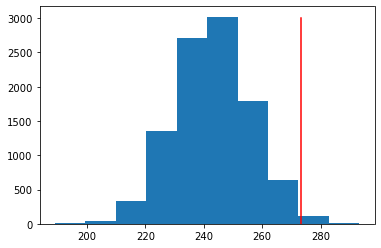

In [59]:
bootstrap_plt = plt.hist(bootstrap_means)

plt.plot([np.percentile(bootstrap_means, 99)] * 4, np.arange(0,3001,1000), color='red')

In [34]:
service_names_sig_max = service_name_avgs[service_name_cnts > 2000] > np.percentile(bootstrap_means, 99)
service_names_sig_min =  service_name_avgs[service_name_cnts > 2000] < np.percentile(bootstrap_means, 1)
service_names_sig = service_names_sig_max | service_names_sig_min
service_names_sig = service_names_sig[service_names_sig == True].index
service_name_avgs[service_names_sig]

service_name
Shared Mobility Device                       0.000000
Other                                       89.021543
Traffic Signal Issue                       171.277940
Missed Collection                          207.633320
Illegal Dumping                            208.058094
Encampment                                 288.807624
Tree Maintenance                           327.248160
Graffiti                                   373.945491
Parking                                    401.670196
Sidewalk Repair Issue                      595.778915
Street Light Maintenance                   599.514026
Environmental Services Code Compliance     773.192943
Graffiti - Code Enforcement               1081.896557
Traffic Sign Maintenance                  1158.545185
Name: payment_diff, dtype: float64

In [35]:
sig_rows = valid_cleared.service_name.apply(lambda x: x in service_names_sig)
sig_df = valid_cleared[sig_rows.values].reset_index(drop=True)
sig_df.dropna(inplace=True)

prio_high_cutoff = np.percentile(sig_df.payment_diff, 80)
sig_df['payment_prio'] = sig_df.payment_diff.apply(categorize_differences, args=(0,prio_high_cutoff))


sig_df

,service_request_id,date_requested,case_age_days,service_name,date_closed,zipcode,case_origin,geometry,pole,poles,payment_before,payment_after,payment_diff,payment_prio
1,3217496,2021-01-24T16:46:00,8.0,Graffiti,2021-02-01,92101,Mobile,POINT (-13043937.428 3859900.013),P-2912,True,0,0,0,No Priority
2,3367308,2021-05-24T12:25:00,2.0,Graffiti,2021-05-26,92101,Mobile,POINT (-13043901.023 3859903.855),P-2912,True,0,0,0,No Priority
4,3391598,2021-06-12T19:20:00,3.0,Graffiti,2021-06-15,92101,Mobile,POINT (-13043913.654 3859915.362),P-2912,True,0,125,125,Low Priority
6,3217496,2021-01-24T16:46:00,8.0,Graffiti,2021-02-01,92101,Mobile,POINT (-13043937.428 3859900.013),P-2912,True,0,0,0,No Priority
7,3367308,2021-05-24T12:25:00,2.0,Graffiti,2021-05-26,92101,Mobile,POINT (-13043901.023 3859903.855),P-2912,True,0,0,0,No Priority
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192035,3493973,2021-09-03T07:33:00,0.0,Parking,2021-09-03,92116,Mobile,POINT (-13040620.243 3863161.009),PB-4409,True,0,0,0,No Priority
192040,3404846,2021-06-23T08:51:00,1.0,Tree Maintenance,2021-06-24,92116,Mobile,POINT (-13040513.718 3863207.181),ME-1806,True,355,185,-170,No Priority
192041,3483863,2021-08-25T20:24:00,1.0,Parking,2021-08-26,92116,Mobile,POINT (-13040530.216 3863225.233),ME-1806,True,357,0,-357,No Priority
192044,3377944,2021-06-01T19:45:00,28.0,Graffiti,2021-06-29,92116,Mobile,POINT (-13040527.006 3863231.801),ME-1806,True,5096,5963,867,Low Priority


<AxesSubplot:>

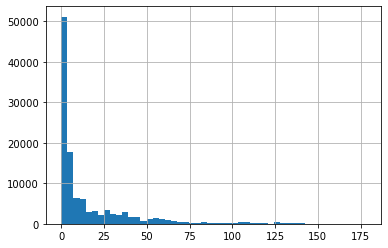

In [36]:
sig_df.case_age_days.hist(bins=50)

<AxesSubplot:xlabel='case_age_days', ylabel='payment_diff'>

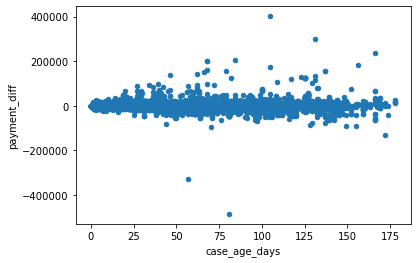

In [37]:
sig_df.plot(x='case_age_days', y='payment_diff', kind='scatter')

In [38]:
col_names = np.concatenate((service_names_sig.values, ['payment_before']))
#col_names = np.append(service_names_sig.values, sig_df.pole.unique())

In [39]:
X = sig_df.loc[:,['service_name', 'payment_before']]
one_hotter = OneHotEncoder(sparse=False)
normer = StandardScaler()
sig_transformer = ColumnTransformer([('categories', one_hotter, ['service_name']),
                                     ('numerical', normer, ['payment_before'])])
X = pd.DataFrame(sig_transformer.fit_transform(X), columns=col_names)
y = sig_df['payment_prio']


In [40]:
#test and rest sets
X_rest,X_test,y_rest,y_test = train_test_split(X,y, test_size=0.3, random_state=32)
#train and validation sets made from rest set

In [41]:
X_train,X_val,y_train,y_val = train_test_split(X_rest,y_rest, test_size=0.2, random_state=32)

In [42]:
def score(preds, og):
    return 1 - ((((og-preds)**2).sum()) / (((og-og.mean())**2).sum()))

In [43]:
log_reg_mdl = LogisticRegression(max_iter=1000)
nb_mdl = GaussianNB()
knn_mdl = KNeighborsClassifier()
svc_mdl = SVC()
ada_mdl = AdaBoostClassifier(base_estimator=Perceptron(),
                             n_estimators=100, 
                             learning_rate=1,
                             algorithm='SAMME',
                             random_state=32)
rf_mdl = RandomForestClassifier(n_estimators=100, 
                                random_state=32)

model_arr = [log_reg_mdl, nb_mdl, knn_mdl, svc_mdl, ada_mdl, rf_mdl]

for model in model_arr:
    model.fit(X_train, y_train)
    model_preds = model.predict(X_val)
    print(classification_report(y_val,model_preds, target_names=['High', 'Low', 'No']))

D:\anaconda\envs\parking\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\envs\parking\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\envs\parking\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        High       0.46      0.05      0.10      3285
         Low       0.00      0.00      0.00      3792
          No       0.56      0.98      0.71      9046

    accuracy                           0.56     16123
   macro avg       0.34      0.34      0.27     16123
weighted avg       0.41      0.56      0.42     16123

              precision    recall  f1-score   support

        High       0.36      0.37      0.37      3285
         Low       0.27      0.81      0.41      3792
          No       0.81      0.13      0.22      9046

    accuracy                           0.34     16123
   macro avg       0.48      0.44      0.33     16123
weighted avg       0.59      0.34      0.29     16123



D:\anaconda\envs\parking\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

        High       0.42      0.44      0.43      3285
         Low       0.44      0.40      0.42      3792
          No       0.70      0.72      0.71      9046

    accuracy                           0.59     16123
   macro avg       0.52      0.52      0.52     16123
weighted avg       0.58      0.59      0.58     16123



D:\anaconda\envs\parking\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\envs\parking\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\envs\parking\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        High       0.48      0.18      0.26      3285
         Low       0.00      0.00      0.00      3792
          No       0.57      0.95      0.71      9046

    accuracy                           0.57     16123
   macro avg       0.35      0.37      0.32     16123
weighted avg       0.42      0.57      0.45     16123

              precision    recall  f1-score   support

        High       0.41      0.26      0.32      3285
         Low       0.29      0.58      0.39      3792
          No       0.57      0.41      0.48      9046

    accuracy                           0.42     16123
   macro avg       0.43      0.42      0.40     16123
weighted avg       0.47      0.42      0.43     16123

              precision    recall  f1-score   support

        High       0.49      0.39      0.44      3285
         Low       0.45      0.44      0.45      3792
          No       0.70      0.76      0.73      9046

    accuracy        

In [44]:
#HYPERPARAMETER TUNING (Commented out for speed)

# knn_params = {'n_neighbors': [5,7]}
# svc_params = {'C':[0.7,1,1.5],
#               'class_weight': ['balanced'],
#               'random_state': [32]}
# ada_params = {'base_estimator': [base_perceptron],
#               'n_estimators' : [200, 500, 700],
#               'learning_rate' : [0.7, 1, 1.3],
#               'random_state': [32]}
# rf_params = {'n_estimators' : [300, 500, 800],
#              'min_samples_split': [3],
#              'max_features': [0.3,'sqrt'],
#              'random_state': [32],
#              'class_weight': ['balanced']}


# knn_grid = GridSearchCV(knn_mdl, knn_params)
# knn_grid.fit(X_train, y_train)

# svc_grid = GridSearchCV(svc_mdl, svc_params, verbose=2)
# svc_grid.fit(X_train, y_train)

# ada_grid = GridSearchCV(ada_mdl, ada_params, verbose=2)
# ada_grid.fit(X_train, y_train)

# rf_grid = GridSearchCV(rf_mdl, rf_params, verbose=3)
# rf_grid.fit(X_train, y_train)

In [45]:
#rf_grid.best_params_
rf_best_params = {'class_weight': 'balanced',
                  'max_features': 0.3,
                  'min_samples_split': 3,
                  'n_estimators': 500,
                  'random_state': 32}

In [46]:
#knn_grid.best_params_
knn_best_params = {'n_neighbors': 7}

In [47]:
#ada_grid.best_params_
ada_best_params = {'base_estimator': Perceptron(max_iter=300, random_state=32),
                   'learning_rate': 1.3,
                   'n_estimators': 200,
                   'algorithm': 'SAMME',
                   'random_state': 32}

In [48]:
#svc_grid.best_params_
svc_best_params = {'C': 1.5, 
                   'class_weight': 'balanced', 
                   'random_state': 32}

In [49]:
tuned_mdl_types = [RandomForestClassifier, KNeighborsClassifier, AdaBoostClassifier, SVC]
tuned_mdl_params = [rf_best_params, knn_best_params, ada_best_params, svc_best_params]

for i in np.arange(len(tuned_mdl_params)):
    mdl_params = tuned_mdl_params[i]
    tune_mdl = tuned_mdl_types[i](**mdl_params)
    tune_mdl.fit(X_train, y_train)
    preds = tune_mdl.predict(X_val)
    print(classification_report(y_val, preds))

               precision    recall  f1-score   support

High Priority       0.46      0.45      0.45      3285
 Low Priority       0.44      0.54      0.49      3792
  No Priority       0.75      0.68      0.71      9046

     accuracy                           0.60     16123
    macro avg       0.55      0.56      0.55     16123
 weighted avg       0.62      0.60      0.61     16123



D:\anaconda\envs\parking\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


               precision    recall  f1-score   support

High Priority       0.44      0.41      0.42      3285
 Low Priority       0.45      0.41      0.43      3792
  No Priority       0.69      0.74      0.71      9046

     accuracy                           0.59     16123
    macro avg       0.53      0.52      0.52     16123
 weighted avg       0.58      0.59      0.59     16123

               precision    recall  f1-score   support

High Priority       0.40      0.44      0.42      3285
 Low Priority       0.30      0.04      0.07      3792
  No Priority       0.60      0.80      0.68      9046

     accuracy                           0.54     16123
    macro avg       0.43      0.42      0.39     16123
 weighted avg       0.49      0.54      0.48     16123

               precision    recall  f1-score   support

High Priority       0.41      0.60      0.49      3285
 Low Priority       0.33      0.63      0.43      3792
  No Priority       0.76      0.34      0.47      9046

  